In [20]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from support_functions import (atipicosAmissing, graficoVcramer, create_target_variable_boxplots, 
                               crear_data_modelo, glm_stepwise, pseudoR2)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

seed = 42

In [2]:
current_dir = Path.cwd()
DATASETS_LOCATION = os.path.join(current_dir.parent.parent.parent, 'datasets')
MODELS_LOCATION = os.path.join(current_dir.parent.parent, 'models')

In [3]:
df_disease = pd.read_csv(os.path.join(DATASETS_LOCATION, 'blood_samples_dataset.csv'))
var_target = "Disease"

# Esplorazione

In [4]:
# Comprobamos el tipo de formato de las variables variable que se ha asignado en la lectura.
# todas estaaan como queremos
df_disease.dtypes

Glucose                                      float64
Cholesterol                                  float64
Hemoglobin                                   float64
Platelets                                    float64
White Blood Cells                            float64
Red Blood Cells                              float64
Hematocrit                                   float64
Mean Corpuscular Volume                      float64
Mean Corpuscular Hemoglobin                  float64
Mean Corpuscular Hemoglobin Concentration    float64
Insulin                                      float64
BMI                                          float64
Systolic Blood Pressure                      float64
Diastolic Blood Pressure                     float64
Triglycerides                                float64
HbA1c                                        float64
LDL Cholesterol                              float64
HDL Cholesterol                              float64
ALT                                          f

## valores perdidos

In [5]:
# Comprobamos si hay valores nulos en las variables
print(f"hay {df_disease.isna().sum().sum()} valores perdidos")

hay 0 valores perdidos


## Valores erroneos

In [6]:
descriptivos_max_min = round(df_disease.describe().T[['max', 'min']],2)
descriptivos_max_min

,max,min
Glucose,0.99,0.00
Cholesterol,1.00,0.00
Hemoglobin,1.00,0.00
Platelets,1.00,0.00
White Blood Cells,1.00,-0.00
Red Blood Cells,1.00,0.00
Hematocrit,1.00,0.00
Mean Corpuscular Volume,1.00,0.00
Mean Corpuscular Hemoglobin,1.00,-0.00
Mean Corpuscular Hemoglobin Concentration,1.00,0.00


Tutti i valori sono correttamente fra 0 e 1


## Datos atipicos

In [7]:
# La proporción de valores atípicos se calcula dividiendo la cantidad de valores atípicos por el número total de filas
numericas_input = df_disease.select_dtypes(include = ['int', 'int32', 'int64','float', 'float32', 'float64']).columns
resultados = {x: atipicosAmissing(df_disease[x])[1] / len(df_disease) for x in numericas_input}
resultados = {key: value for key, value in resultados.items() if value!= 0} # elimino la variable si no tiene valores atipicos
if resultados:
    for key, value in resultados.items():
        print(f'{key}: {round(value*100,2)}% de valores atipicos en la variable')
else:
    print("No hay datos atipicos")

No hay datos atipicos


## Distibucion variable target

In [8]:
df_disease[var_target].value_counts()

Disease
Diabetes    834
Anemia      707
Healthy     561
Thalasse    557
Thromboc    139
Heart Di     39
Name: count, dtype: int64

Rinominiamo le variabili target ed eliminiamo heard di

In [9]:
# Rinomina "Thalasse" in "Thalassemia" e "Thromboc" in "Thrombosis"
df_disease[var_target] = df_disease[var_target].replace({
    'Thalasse': 'Thalassemia',
    'Thromboc': 'Thrombosis'
})

# Rimuove le righe con "Heart Di"
df_disease = df_disease[df_disease[var_target] != 'Heart Di']

# Visualizza il conteggio delle malattie aggiornato
print(df_disease[var_target].value_counts())

Disease
Diabetes       834
Anemia         707
Healthy        561
Thalassemia    557
Thrombosis     139
Name: count, dtype: int64


## Correlacion entre variables

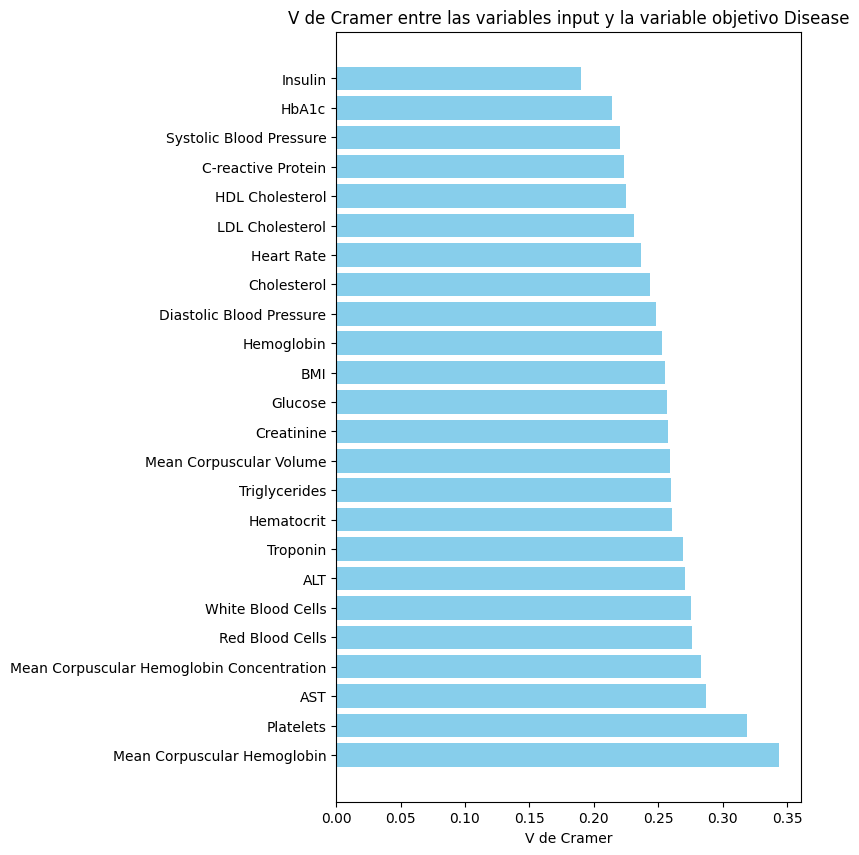

{'Mean Corpuscular Hemoglobin': 0.3435722528967313,
 'Platelets': 0.3187702624531197,
 'AST': 0.28735863127411865,
 'Mean Corpuscular Hemoglobin Concentration': 0.28292157988652966,
 'Red Blood Cells': 0.2757430972696437,
 'White Blood Cells': 0.2755488463251754,
 'ALT': 0.27029673838408164,
 'Troponin': 0.26946401696525846,
 'Hematocrit': 0.2605545295361615,
 'Triglycerides': 0.25961671658786817,
 'Mean Corpuscular Volume': 0.25874336395395536,
 'Creatinine': 0.25784426592757037,
 'Glucose': 0.25640352378625964,
 'BMI': 0.25547676678459463,
 'Hemoglobin': 0.25316357228348,
 'Diastolic Blood Pressure': 0.24836291488530532,
 'Cholesterol': 0.24338911973816213,
 'Heart Rate': 0.23671738116169708,
 'LDL Cholesterol': 0.23103428924150282,
 'HDL Cholesterol': 0.22517992182149074,
 'C-reactive Protein': 0.2230886805522568,
 'Systolic Blood Pressure': 0.2202299294519316,
 'HbA1c': 0.21397251873059836,
 'Insulin': 0.19011220727152253}

In [10]:
graficoVcramer(df_disease.drop(columns=[var_target]), df_disease[var_target])

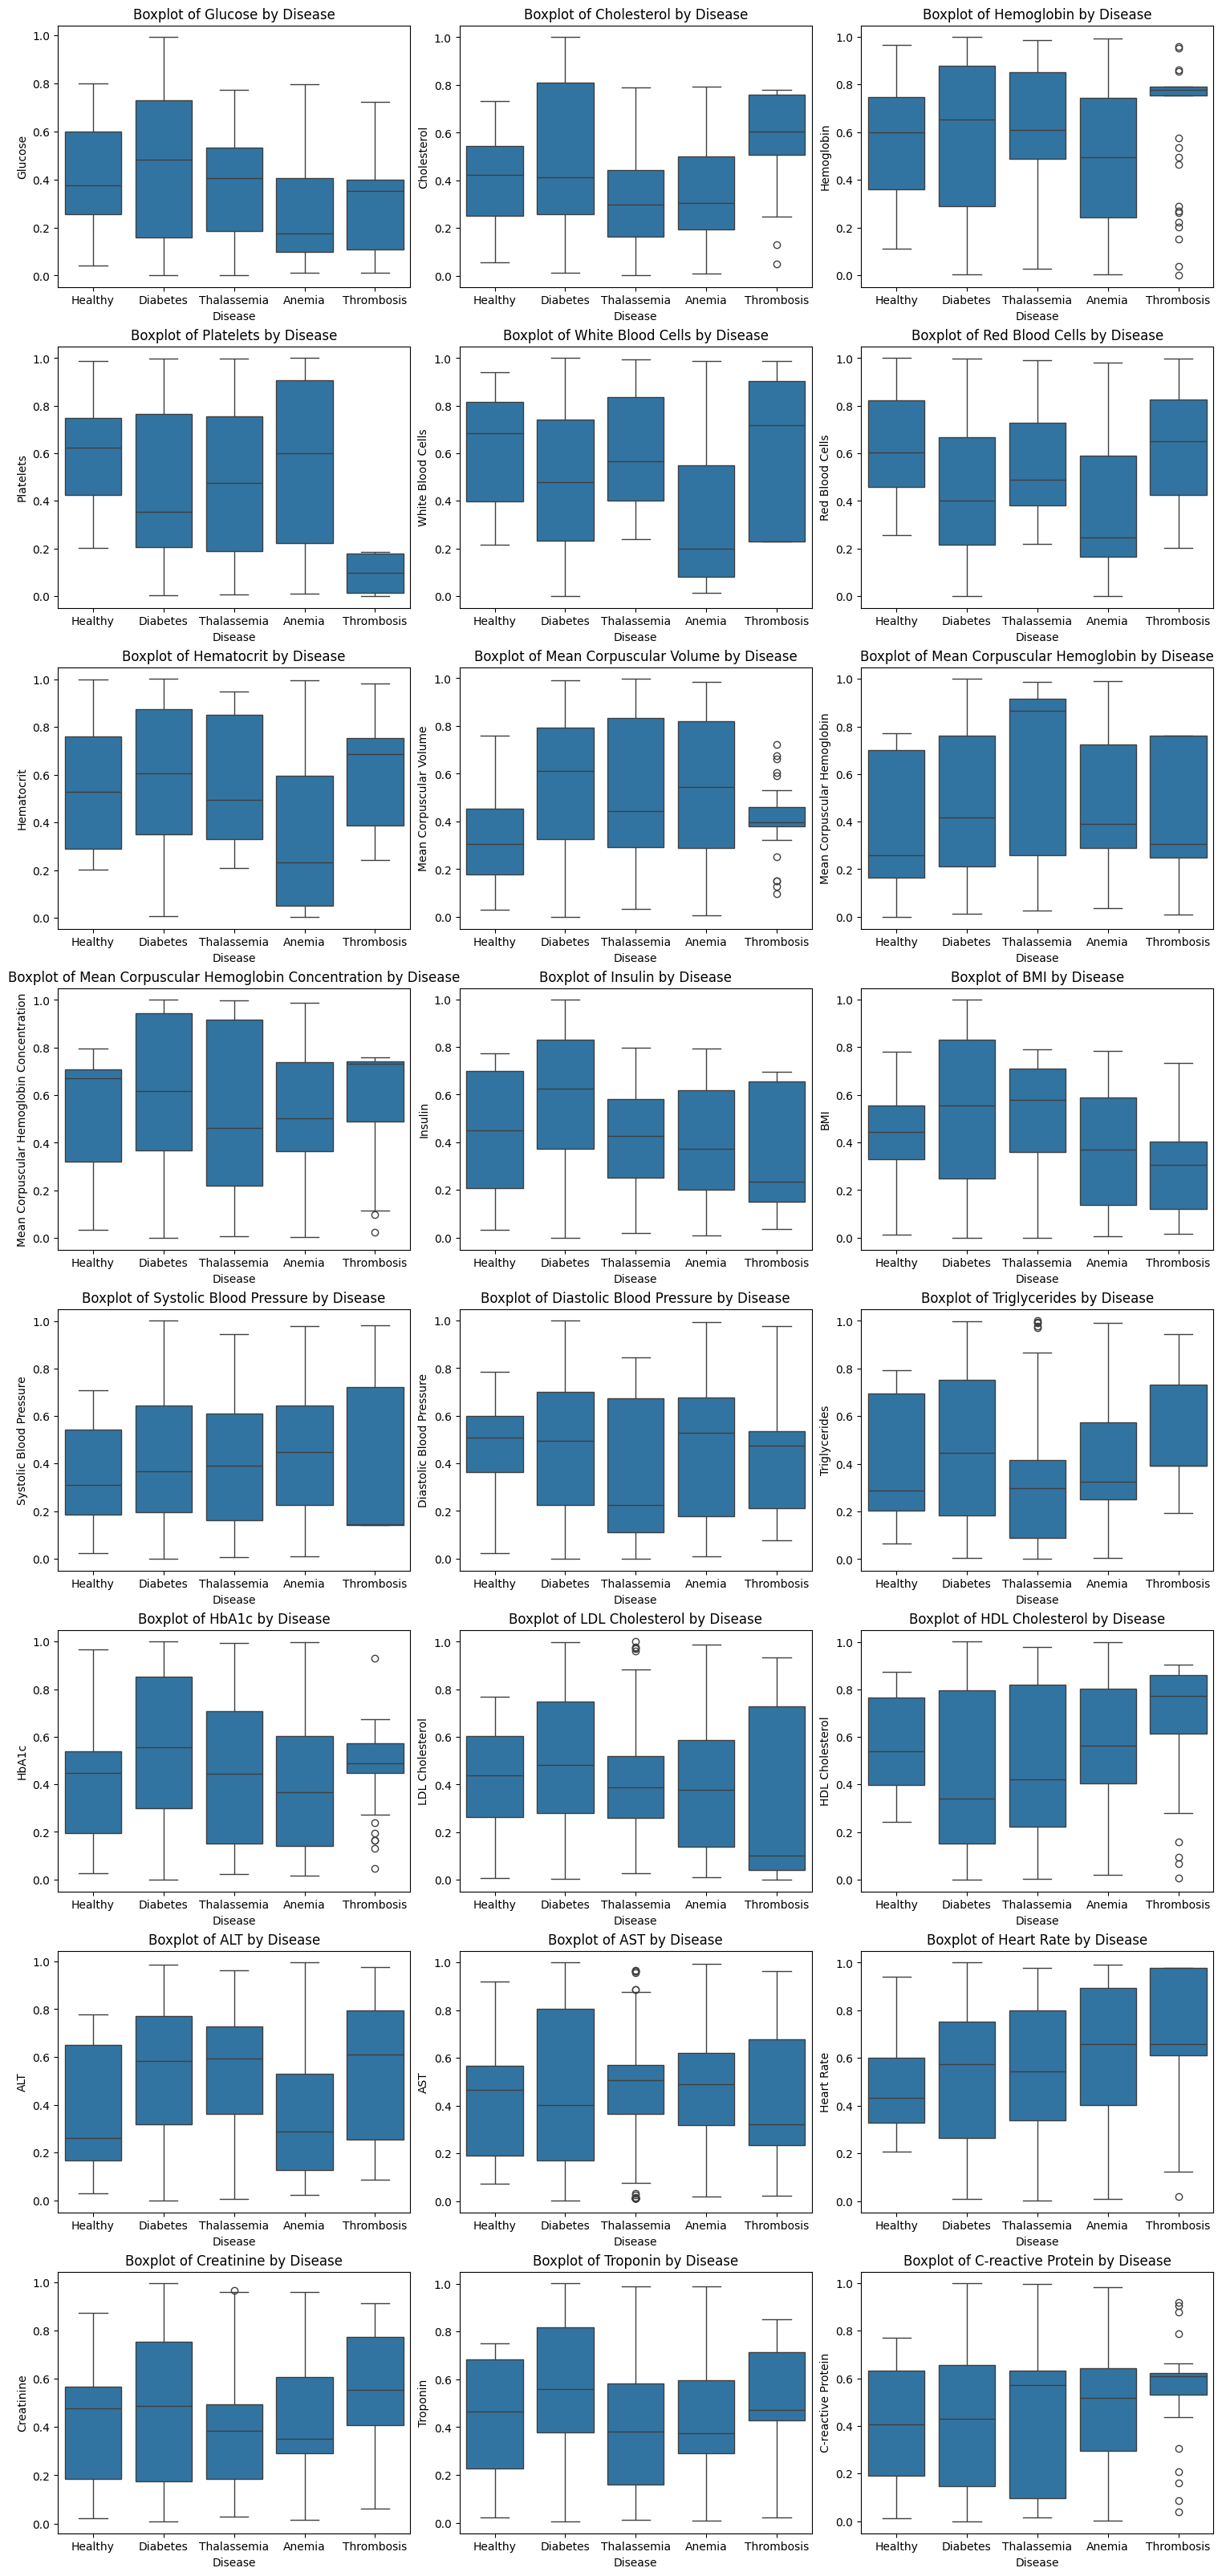

In [11]:
create_target_variable_boxplots(dataframe=df_disease,
                                target_col=var_target)

## Correlación entre todas las variables numéricas

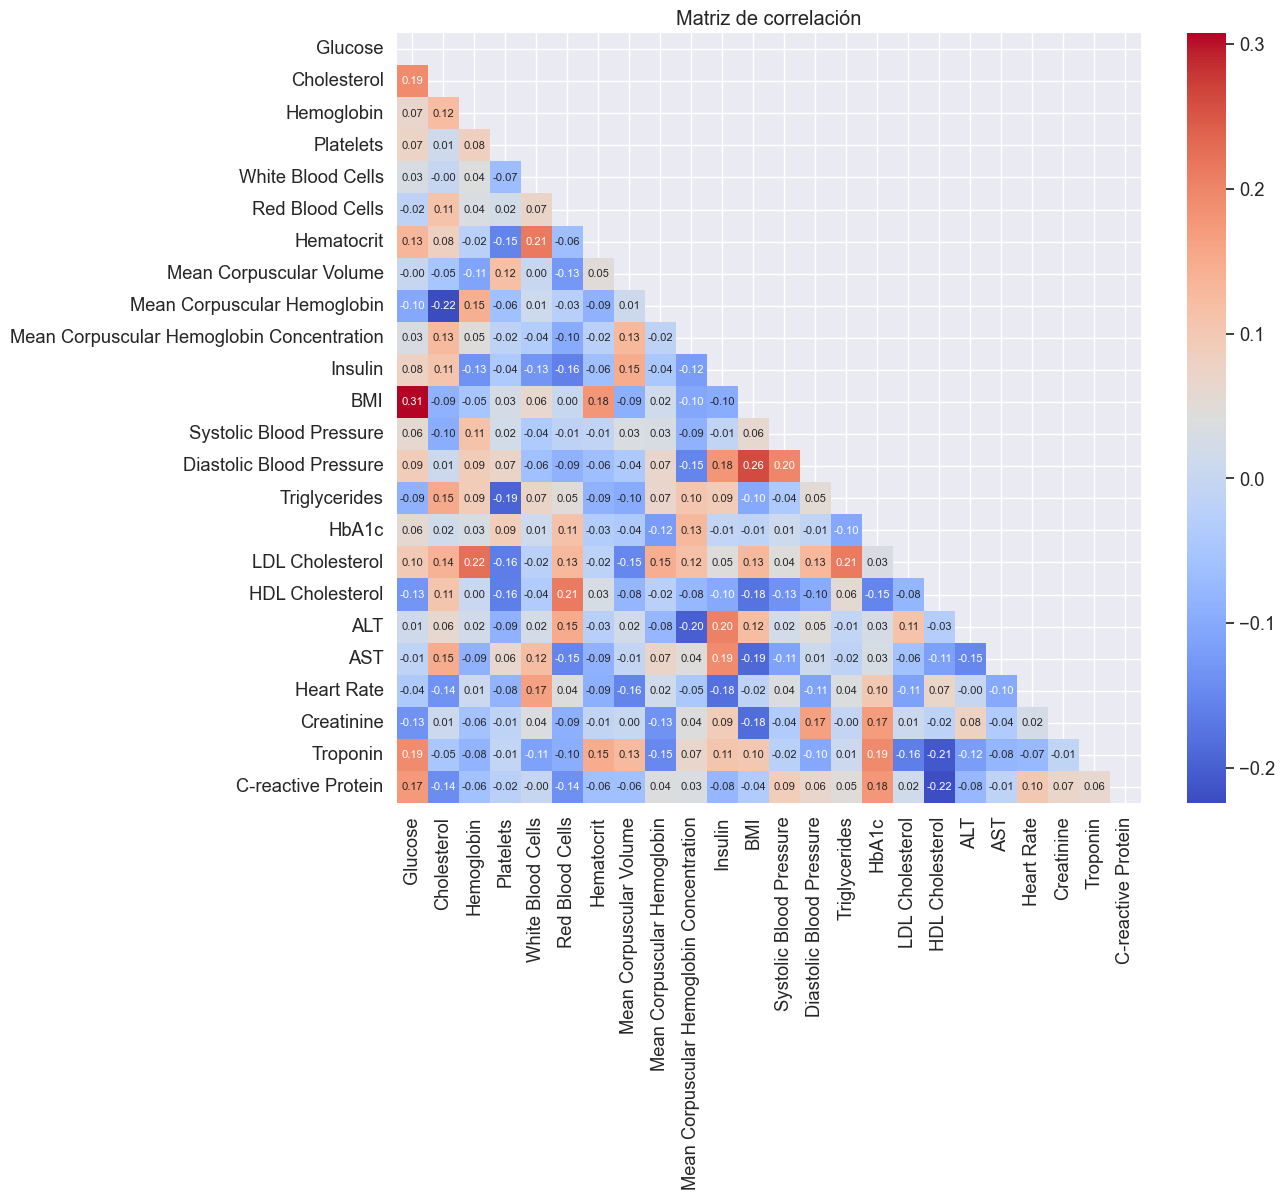

In [12]:
# Obtener las columnas numéricas del DataFrame 'datos_input'
numericas = df_disease.select_dtypes(include=['int', 'float']).columns
# Calcular la matriz de correlación de Pearson entre la variable objetivo continua ('varObjCont') y las variables numéricas
matriz_corr = df_disease[numericas].corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
# Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
plt.figure(figsize=(12, 10))
# Establecer el tamaño de fuente en el gráfico
sns.set(font_scale=1.2)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask, annot_kws={"size": 8})
# Establecer el título del gráfico
plt.title("Matriz de correlación")
# Mostrar el gráfico de la matriz de correlación
plt.show()

Non c'e' una correlazione evidente fra le varie variabili del dataset

# Train test split

In [17]:
X = df_disease.drop(columns=[var_target])  
y = df_disease[var_target]  # La variable objetivo

# Realizamos el train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# One-Hot Encoding para la variable target
encoder = OneHotEncoder(sparse_output=False)  
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Mostrar las nuevas categorías de la variable target
print(f"Categorías codificadas: {encoder.categories_} \n")
y_train_encoded

print(f"Tamaño del dataset de entrenamiento: {len(X_train)}")
print(f"Tamaño del dataset de prueba: {len(X_test)}")

Categorías codificadas: [array(['Anemia', 'Diabetes', 'Healthy', 'Thalassemia', 'Thrombosis'],
      dtype=object)] 

Tamaño del dataset de entrenamiento: 2238
Tamaño del dataset de prueba: 560


Siccome i valori hanno massimo 1 (solo in un caso 0.99) e minimo 0, normalizzare i dati sarebbe inutile.

# SVM

## Addestramento

In [21]:
# Pipeline con standardizzazione delle variabili numeriche e modello SVM
svm_pipeline = Pipeline([
    ('svm', SVC(kernel='linear', probability=True, random_state=seed))  # Modello SVM con kernel lineare
])

# Addestramento del modello
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('svm',
                 SVC(kernel='linear', probability=True, random_state=42))])

## Valutazione

In [23]:
# Predizioni sul set di test
y_pred = svm_pipeline.predict(X_test)

# Report di classificazione
print("\nReport di classificazione:\n")
print(classification_report(y_test, y_pred))


Report di classificazione:

              precision    recall  f1-score   support

      Anemia       0.89      0.97      0.93       150
    Diabetes       0.83      0.84      0.83       170
     Healthy       0.95      0.92      0.94       117
 Thalassemia       0.93      0.84      0.88        95
  Thrombosis       0.96      0.86      0.91        28

    accuracy                           0.89       560
   macro avg       0.91      0.88      0.90       560
weighted avg       0.89      0.89      0.89       560



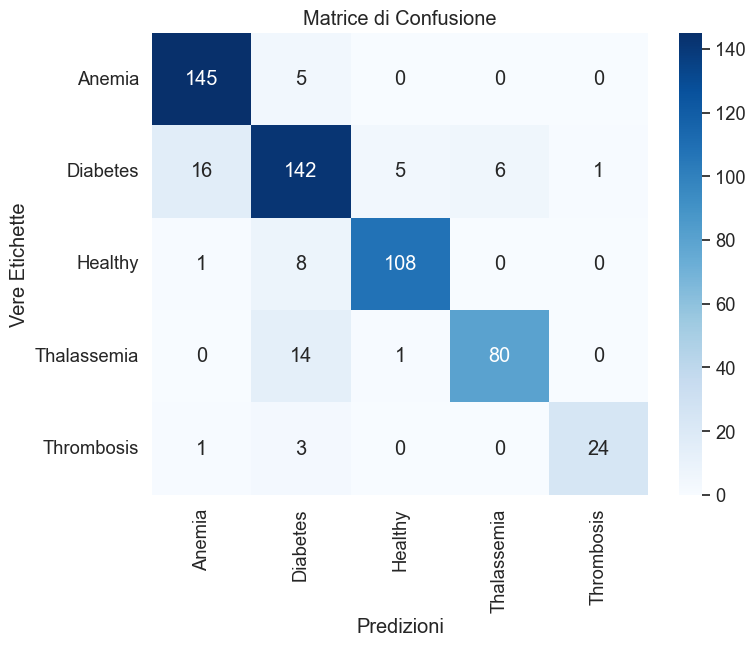

In [26]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
class_names = encoder.categories_[0]

# Visualizzare la matrice di confusione usando heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predizioni')
plt.ylabel('Vere Etichette')
plt.title('Matrice di Confusione')
plt.show()

# KNN neighbours

## Preprocessing

I dati non hanno valori atipici o mancanti, inoltre sono gia' normalizzati. Non occorre quindi preprocessing

## Training

In [20]:
KNN=KNeighborsClassifier()

KNN.fit(X_train, y_train) ## entrenando
print('Accuracy del modelo en train: %.3f' %KNN.score(X_train, y_train), 
      'Accuracy del modelo en test: %.3f ' %KNN.score(X_test, y_test))

Accuracy del modelo en train: 0.927 Accuracy del modelo en test: 0.918 


### Bagging

In [ ]:
# TODO VALORI FRA MAX E MIN
n_estimators_list = [50, 100, 200]
max_samples_list = [0.5, 0.7, 0.8]
max_features_list = [0.2, 0.3]
n_neighbors_list = [2, 3, 4]

results_knn = []

for n_estimators in n_estimators_list:
    print(f"processing {n_estimators} estimators")
    for max_samples in max_samples_list:
        print(f"processing {max_samples} max_samples")
        for max_features in max_features_list:
            for n_neighbors in n_neighbors_list:
                # Crea el clasificador Bagging con KNN
                bagging_model = BaggingClassifier(
                    KNeighborsClassifier(n_neighbors=n_neighbors),
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    max_features=max_features,
                    bootstrap_features=True,
                    random_state=seed
                )
                
                # Adiestra el clasificador Bagging
                bagging_model.fit(X_train, y_train)
                
                train_score = bagging_model.score(X_train, y_train)
                test_score = bagging_model.score(X_test, y_test)
                
                results_knn.append({
                    'n_estimators': int(n_estimators),
                    'max_samples': max_samples,
                    'max_features': max_features,
                    'n_neighbors': n_neighbors,
                    'train_score': train_score,
                    'test_score': test_score
                })

# Crea un DataFrame con los resultados
results_knn_df = pd.DataFrame(results_knn)

processing 50 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples
processing 100 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples
processing 200 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples


## Evaluacion

In [31]:
results_knn_df = results_knn_df.sort_values('test_score', ascending=False).head()
results_knn_df.head(3)

,n_estimators,max_samples,max_features,n_neighbors,train_score,test_score
21,100,0.5,0.3,2,0.986595,0.957143
41,200,0.5,0.3,4,0.971403,0.957143
39,200,0.5,0.3,2,0.989723,0.957143


In [32]:
best_params_bag_knn = dict(results_knn_df.iloc[0][['n_estimators','max_samples','max_features']])
best_params_bag_knn['n_estimators'] = int(best_params_bag_knn['n_estimators'])
best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])
best_params_bag_knn, best_knn_neighb

C:\Users\maria\AppData\Local\Temp\ipykernel_24704\205366803.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])


({'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.3}, 2)

Realicemos la validación cruzada y obtengamos los resultados:

In [33]:
best_model_bagging_knn = BaggingClassifier(
                                            KNeighborsClassifier(n_neighbors=best_knn_neighb),
                                            **best_params_bag_knn,
                                            bootstrap_features=True,
                                            random_state=seed
                                        )

cv_scores = cross_val_score(best_model_bagging_knn, X_train, y_train, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95040214 0.94369973 0.94235925]
Accuracy media de la validación cruzada: 0.945
Desviación estándar de las diferentes accuracys de la CV: 0.004


Calculemos la accuracy en train y en test para el mejor modelo obtenido:

In [34]:
best_model_bagging_knn.fit(X_train, y_train)
best_y_pred_gab_knn_test = best_model_bagging_knn.predict(X_test)
best_y_pred_gab_knn_train = best_model_bagging_knn.predict(X_train)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,best_y_pred_gab_knn_train)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,best_y_pred_gab_knn_test)}')

Se tiene un accuracy para train de: 0.9865951742627346
Se tiene un accuracy para test de: 0.9571428571428572


Il modello KNN prese